<a href="https://colab.research.google.com/github/asabbah44/Text_Classification/blob/main/WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

In [38]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [39]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/dataset.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/mydataset.csv')


df1 = pd.DataFrame(df1, columns = ['commenttext','label'])
df2 = pd.DataFrame(df2, columns = ['commenttext','label'])

df=pd.concat([df1,df2])

In [40]:
# possible_labels = df.label.unique()
# label_dict = {}
# for index, possible_label in enumerate(possible_labels):
#     label_dict[possible_label] = index
# print(label_dict)
# df['label'] = df.label.replace(label_dict)

# df.head()

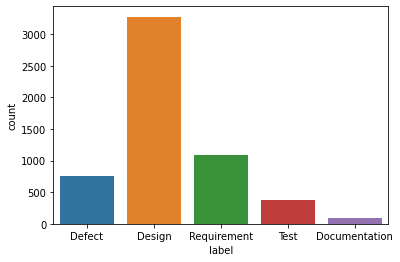

In [41]:
import seaborn as sns

sns.countplot(x='label', data=df)

In [42]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

from Utility import preprocess
df["commenttext"] = df["commenttext"].apply(lambda x: x.lower())

# Clean the text
df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.clean_text(x))

# Clean numbers
df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.clean_numbers(x))

# Clean Contractions
df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.replace_contractions(x))
 
df["commenttext"] = df["commenttext"].apply(lambda x:preprocess.clean_punc(x))

# lemmatize
df["commenttext"] = df["commenttext"].apply(lambda x: preprocess.lemmatize(x))
# remove stop word and custome word such as todo
df["commenttext"] = df["commenttext"].apply(lambda x: preprocess.custm_stopwords_remove(x))







In [43]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [44]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [45]:
X = []
sentences = list(df['commenttext'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [46]:
X[2]

'hate admit know happened throw exception'

Label encoder

In [47]:
df.label.unique()

array(['Defect', 'Design', 'Requirement', 'Test', 'Documentation'],
      dtype=object)

In [48]:
y = df['label']

y = np.array(list(map(lambda x: 0 if x=="Requirement" else 1 if x=="Design" else 2 if x=="Defect" else 3 if x=="Test" else 4, y)))


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



In [50]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train = le.fit_transform(y_train.values)
# y_test = le.transform(y_test.values)

In [51]:
from nltk.tokenize import word_tokenize

all_words = []
for sent in X:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [52]:
unique_words = set(all_words)

No_Of_Words=(len(unique_words))
print(No_Of_Words)

8083


In [53]:
tokenizer = Tokenizer(num_words=No_Of_Words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
MaxWordsLen=700

In [55]:
vocab_size = len(tokenizer.word_index) + 1

# max number of words in sentencecs
maxlen = MaxWordsLen

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [56]:
vocab_size 

7128

In [57]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.840B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split(" ")
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [58]:
WordsNotInclude=[]
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else : WordsNotInclude.append(word)

In [59]:
len(WordsNotInclude)

2548

In [92]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [93]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 700, 300)          2138400   
_________________________________________________________________
flatten_3 (Flatten)          (None, 210000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1050005   
Total params: 3,188,405
Trainable params: 1,050,005
Non-trainable params: 2,138,400
_________________________________________________________________
None


In [94]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
28/28 [==============================] - 1s 43ms/step - loss: 1.2899 - acc: 0.5240 - val_loss: 1.0441 - val_acc: 0.6376
Epoch 2/6
28/28 [==============================] - 1s 38ms/step - loss: 0.8673 - acc: 0.6834 - val_loss: 0.9487 - val_acc: 0.6711
Epoch 3/6
28/28 [==============================] - 1s 38ms/step - loss: 0.7139 - acc: 0.7518 - val_loss: 0.9070 - val_acc: 0.7136
Epoch 4/6
28/28 [==============================] - 1s 38ms/step - loss: 0.6296 - acc: 0.7905 - val_loss: 0.8755 - val_acc: 0.7159
Epoch 5/6
28/28 [==============================] - 1s 38ms/step - loss: 0.5669 - acc: 0.8165 - val_loss: 0.8633 - val_acc: 0.7181
Epoch 6/6
28/28 [==============================] - 1s 38ms/step - loss: 0.5322 - acc: 0.8249 - val_loss: 0.8543 - val_acc: 0.7215


In [95]:
score = model.evaluate(X_test, y_test, verbose=1)

35/35 [==============================] - 0s 9ms/step - loss: 0.8631 - acc: 0.6992


In [65]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8047646880149841
Test Accuracy: 0.7170993685722351


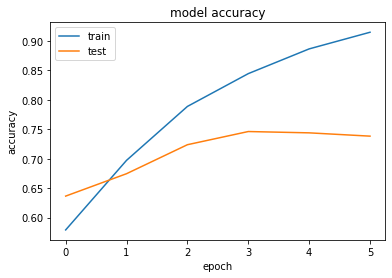

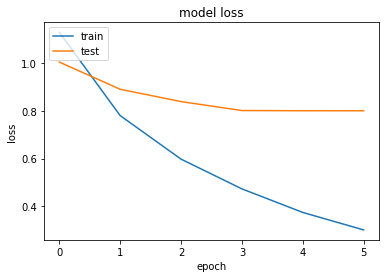

In [66]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

CNN

In [100]:
from keras.layers import Conv1D, MaxPooling1D, Embedding
model = Sequential()

embedding_layer = Embedding( vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=True)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [101]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 700, 300)          2138400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 696, 128)          192128    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 2,331,173
Trainable params: 2,331,173
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
35/35 [==============================] - 4s 101ms/step - loss: 0.4177 - acc: 0.8536
Epoch 2/10
35/35 [==============================] - 3s 97ms/step - loss: 0.1684 - acc: 0.9568
Epoch 3/10
35/35 [==============================] - 3s 98ms/step - loss: 0.1005 - acc: 0.9807
Epoch 4/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0691 - acc: 0.9888
Epoch 5/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0561 - acc: 0.9895
Epoch 6/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0467 - acc: 0.9922
Epoch 7/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0408 - acc: 0.9931
Epoch 8/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0376 - acc: 0.9933
Epoch 9/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0350 - acc: 0.9931
Epoch 10/10
35/35 [==============================] - 0s 10ms/step - loss: 0.8213 - acc: 0.7619


In [104]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.8212652206420898
Test Accuracy: 0.7618621587753296


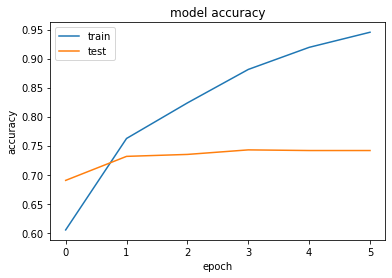

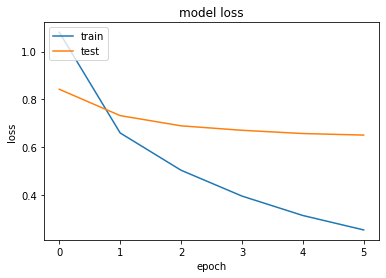

In [71]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

LSTM

In [72]:
from keras.layers import Dense,LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [73]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 700, 300)          2138400   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 2,358,693
Trainable params: 220,293
Non-trainable params: 2,138,400
_________________________________________________________________
None


In [74]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
28/28 [==============================] - 5s 116ms/step - loss: 1.4452 - acc: 0.5240 - val_loss: 1.1615 - val_acc: 0.5872
Epoch 2/6
28/28 [==============================] - 3s 101ms/step - loss: 1.1434 - acc: 0.5935 - val_loss: 1.1574 - val_acc: 0.5872
Epoch 3/6
28/28 [==============================] - 3s 101ms/step - loss: 1.1322 - acc: 0.5924 - val_loss: 1.1560 - val_acc: 0.5872
Epoch 4/6
28/28 [==============================] - 3s 100ms/step - loss: 1.1639 - acc: 0.5810 - val_loss: 1.1566 - val_acc: 0.5872
Epoch 5/6
28/28 [==============================] - 3s 101ms/step - loss: 1.1465 - acc: 0.5876 - val_loss: 1.1608 - val_acc: 0.5872
Epoch 6/6
35/35 [==============================] - 1s 21ms/step - loss: 1.1435 - acc: 0.5944


In [75]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.1435426473617554
Test Accuracy: 0.5944494009017944


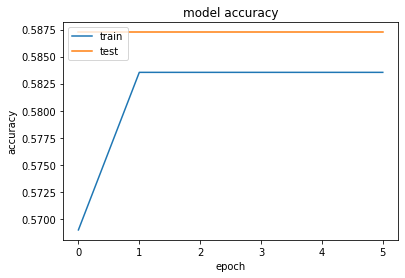

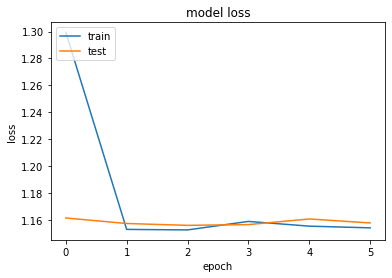

In [76]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()